In [1]:
from scipy.stats import norm

In [9]:
import numpy as np
import pandas as pd
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian

from scipy.integrate import quad
from scipy.stats import norm
from numba import jit
from scipy import interpolate
import matplotlib.pyplot as plt


In [15]:
norm.cdf(1)

0.8413447460685429

In [11]:
def g_n(x):
    return norm.pdf(x,0,1)
def FX_lock1(X,m,g=g_n):
    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    omega_p = (4/np.pi)*np.sqrt(X/m)

    A = omega_p/X
    if abs(A)<=1:
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
        return I_l
    else: 
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
        return I_l

def FX_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    O_p = (4/np.pi)*np.sqrt(X/m)
    integrand_drift = lambda x:1/(x**2)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -1/(m)*I_d

def FX_0(X,m,O_0,g=g_n):
        O_d = min(O_0,X)
        theta_0 = np.arcsin(O_d/X)
        integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
        integrand_d = lambda x:(1/x**2)*g(x)
        I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
        I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
        Fl = 1*I_l
        Fd = - 1/(m)*I_d
        F0 = Fl + Fd
        return F0,Fl,Fd
get_FX_l1 = np.vectorize(FX_lock1)
get_FX_d1 = np.vectorize(FX_drift1)
get_FX_0 = np.vectorize(FX_0)


def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2(r,K,m,F_R0, g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    # O_pm_shift = O_pm -shift_O
    # shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x)+shift_O,O_r,O_pm)
    O_p = (4/np.pi)*np.sqrt(X/m)

    A = O_p/X
    if abs(A)<=1:
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
        return I_l
    else: 
        I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
        return I_l    
def F_drift2(r,K,m,F_R0,g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    O_p = (4/np.pi)*np.sqrt(X/m)
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    # O_pm_shift = O_pm -shift_O
    # shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 

    integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1/(m)*(I_d)#+I_dm)
def F_sec(r,K,m,F_R0,g=g_sec):
    F_l2 = F_lock2(r,K,m,F_R0, g)
    F_d2 = 0# F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)


def Make_R_function(m,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    return F_RMd,F_RMu,F_R0d,F_R0u

def Make_R0_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2 = get_F2(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,10000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    r_su_l = r_su*K*F_lock2(r_su,K,m,F_R0=FR,g=g_sec)
    r_sd_l = r_sd*K*F_lock2(r_sd,K,m,F_R0=FR,g=g_sec)
    return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np = np.vectorize(get_r_sec)

In [12]:
def F_lock22(r,K,m,F_R0, g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    # shift = -(K**2*r*r_0)/(2*(O_pm)**2)/m - (K**2*r*r)/(8*(O_pm)**2)/m 
    shift = lambda x: -(K**2*r*r_0)/(2*(O_r+X*np.sin(x))**2)/m - (K**2*r*r)/(8*(O_r+X*np.sin(x))**2)/m

    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x)+shift(x),O_r,O_pm)
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x),O_r,O_pm)
    O_p = (4/np.pi)*np.sqrt(X/m)

    A = O_p/X
    A = np.where(abs(A)<=1,A,1)
    # if abs(A)<=1:
    theta_p = np.arcsin(A)
    I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
    return I_l
    

def F_sec2(r,K,m,F_R0,g=g_sec):
    F_l2 = F_lock2(r,K,m,F_R0, g)
    F_d2 = 0#F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2


get_Fp_l2 = np.vectorize(F_lock22)
get_F22 = np.vectorize(F_sec2)
from scipy import interpolate
def get_r_sec2(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2 = get_F22(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,10000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    r_su_l = r_su*K*F_lock22(r_su,K,m,F_R0=FR,g=g_sec)
    r_sd_l = r_sd*K*F_lock22(r_sd,K,m,F_R0=FR,g=g_sec)
    return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np2 = np.vectorize(get_r_sec2)


In [13]:
m = 5
F_RMd,F_RMu,F_R0d,F_R0u =  Make_R_function(m)
Ks_check2 = np.arange(2,6,0.1)
rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=200)


In [23]:
# rs_d2,rs_u2,rs_dFl2,rs_uFl2 = get_r_sec_np(Ks_check2,m,F_R0u,samples=100)

In [14]:
rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=200)


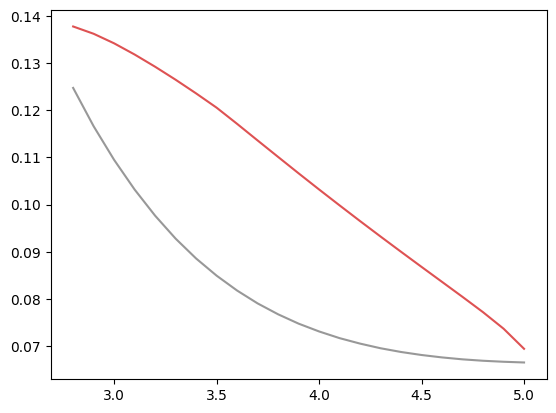

In [25]:
# plt.plot(Ks_check2,rs_dFl2,color='tab:grey')
# plt.plot(Ks_check2,rs_uFl2,color='tab:red')

plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)

In [41]:
rMt438= np.array([0.019406867,0.020722266,0.018413989,0.018403741,0.017038793,0.013238055,0.018679685,0.01473135,0.01561022,0.014388955,0.015492896,0.014429656,0.013533199,0.012612161,0.013993287,0.014136052,0.015435954,0.013805765,0.012942475,0.015522182,0.012952873,0.013353188,0.013582684,0.013644973,0.013354182,0.01175315,0.013640055,0.012382347,0.013107056,0.012951946,0.012562106,0.014184554,0.011222844,0.015439618,0.013545629,0.010986628,0.014207241,0.013865026,0.015818376,0.014575855,0.013457203,0.012830302,0.012837889,0.013465615,0.016628576,0.020092076,0.013558967,0.015493202,0.017346107,0.029125943,0.023294349,0.024278729,0.023875998,0.042548711,0.045423925,0.048296852,0.049299816,0.04978734,0.051029435,0.050346607,0.020817728,0.019906145,0.019085154,0.01979519,0.019303961,0.01806596,0.018161892,0.017619628,0.017170695,0.015773713,0.016612122,0.01646907,0.015601511,0.013810719,0.014297189,0.014250949,0.013983947,0.014146111,0.013919584,0.012325232,0.012268585,0.012718166,0.012643088,0.012067499,0.011756952,0.012304061,0.011571858,0.011526855,0.010886583,0.010981493,0.010294736,0.01037492,0.009819665,0.009664553,0.00933766,0.009601137,0.00978733,0.009210046,0.008477519,0.008631298,0.007802616,0.008445185,0.008655785,0.008266534,0.006483,0.007643856,0.007900246,0.006893774,0.006935902,0.007150152,0.00715529,0.006586128,0.006797654,0.005779657,0.00595423,0.006456816,0.006220216,0.005914185,0.005912468,0.005952055,0.005578732,0.005475276,0.005829946,0.005287704,0.005063555,0.005248785,0.005094982,0.00490787,0.005229491,0.004815326,0.004927816,0.004899739,0.004415427,0.004618246,0.004571841,0.004611702,0.004224007,0.004290041,0.003925013,0.004014108,0.003966919,0.003917458,0.003762472,0.003716797,0.003671664,0.003763017,0.003341392,0.003478076,0.003520413,0.003595959,0.003516796])

In [11]:
Ks = np.arange(0,15.05,0.1)

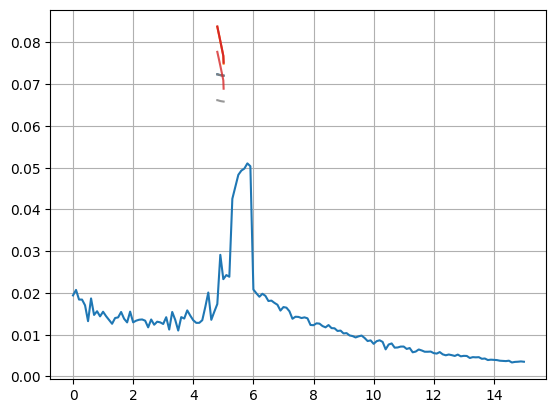

In [66]:

plt.plot(Ks_check2,rs_d2,color='tab:blue')
plt.plot(Ks_check2,rs_u2,color='tab:orange')


plt.plot(Ks_check2,rs_dFl2,color='tab:grey')
plt.plot(Ks_check2,rs_uFl2,color='tab:red')


plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)

plt.plot(Ks,rMt438)
plt.grid()
# plt.ylim(0.05)

# 여러 앙상블을 통해서 확인
2차 클러스터가 형성되는 것은 + cluster의 order parameter가 이론적인 branch에 존재하기 떄문이다. 만일 이 Branch에 도달하지 못하였다면 메인 클러스터만 형성될것이다.  
여러 앙상블을 통해서 secondary cluster의 형성이 어떻게 되는지 확인해 보자

In [2]:
import TO_sim.Q_simul as QSIM

In [ ]:
QSIM.Q_Normal(N=500,m)

In [ ]:
r_clu_info['r_clu'].keys()

dict_keys(['0', '-', '+', '+_total', '-_total'])

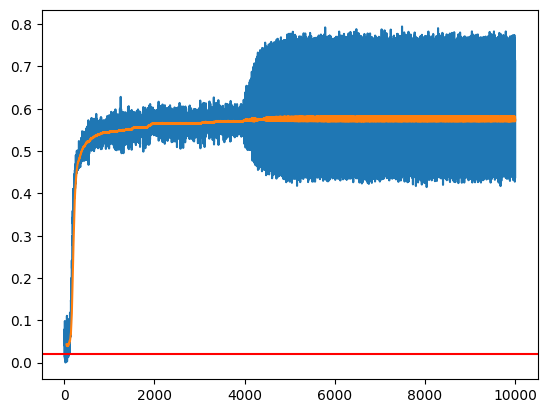

In [ ]:
plt.plot(sol['t'],sol['rs'])
plt.plot(r_clu_info['t_mean'],r_clu_info['r_total_mean'])
plt.axhline(F_RMd(K),color='red')

In [ ]:
rs_d,rs_u,rs_dF,rs_uF = get_r_sec_np2(K,m,F_R0u,samples=30)

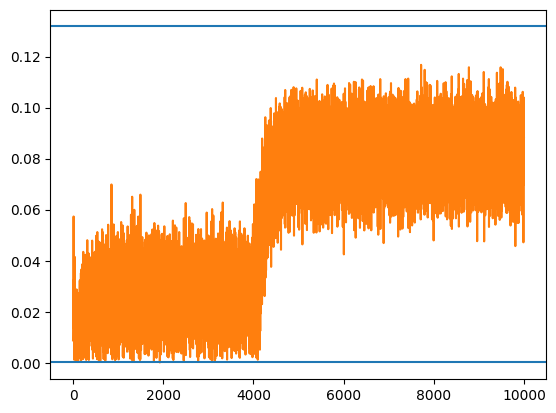

In [ ]:
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['+'])
plt.plot(r_clu_info['t'],r_clu_info['r_clu']['+_total'])
plt.axhline(rs_dF)
plt.axhline(rs_uF)
# plt.plot(r_clu_info['t'],r_clu_info['t'])

In [89]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [2]:
N = 500

In [116]:
m = 5.5
F_RMd,F_RMu,F_R0d,F_R0u =  Make_R_function(m)
Ks_check2 = np.arange(3,9,0.1)
rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=50)


In [105]:
rs_d2,rs_u2,rs_dFl2,rs_uFl2 = get_r_sec_np(Ks_check2,m,F_R0u,samples=50)


In [71]:
np.arange(0,50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [123]:

# F_RMd,F_RMu,F_R0d,F_R0u =  OSP.Make_R_function(m)
N = 1000
K = 4.1
seeds = np.arange(0,5)
df_s = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=5000,seed=seed)
    KM_info = Qsimul.KM_space(4,9,0.2)
    df_s.loc[seed]['KM_info'] = KM_info

# # sol = Qsimul.solve()
# cluster_info = Qsimul.get_cluster()
# r_clu_info = Qsimul.get_r_clu()

# r_clu_info['r_clu_mean_last']
# r_clu_info['r_total_mean'][-1]

  0%|          | 0/5 [00:00<?, ?it/s]

In [96]:
df_s.loc[10]['KM_info'] = KM_info2

In [102]:
df_s.loc[10]['KM_info']

{'Ks': array([5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
        6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. ]),
 'r_info':        r_mean        r0        r+        r-  r+_total  r-_total  sig_mean  \
 5.0  0.651799  0.704085  0.071491  0.075109   0.06943  0.072934  0.091835   
 5.1  0.679124  0.727115  0.064334  0.062795  0.061682  0.059576  0.077018   
 5.2  0.681408  0.727461   0.06382  0.063077  0.060837  0.060361  0.078298   
 5.3  0.683759  0.733862  0.062463  0.062414  0.059435  0.059883  0.075819   
 5.4  0.700331  0.743928   0.05911  0.057704  0.056142  0.054697  0.071571   
 5.5  0.698549  0.748433  0.059783  0.057872  0.057558  0.055024  0.070917   
 5.6  0.705641  0.749526  0.060386  0.059697  0.058184  0.057146   0.07436   
 5.7  0.722621  0.767761  0.050931   0.05188   0.04882  0.049959  0.061861   
 5.8   0.72468  0.769021   0.05402  0.052922   0.05218  0.051144  0.065843   
 5.9  0.740906  0.782162  0.048061  0.048781  0.046007  0.046967  0.059134   
 6.

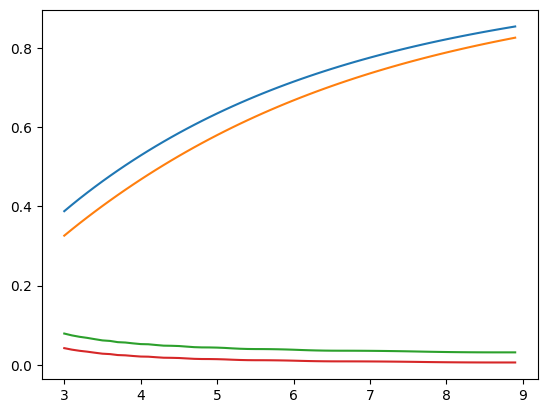

In [119]:
# KM_info2['r_info'].plot()
plt.plot(Ks_check2,F_R0u(Ks_check2))
plt.plot(Ks_check2,F_RMu(Ks_check2))
plt.plot(Ks_check2,F_R0d(Ks_check2))
plt.plot(Ks_check2,F_RMd(Ks_check2))

In [101]:
df_s

StopIteration: 

StopIteration: 

In [107]:
N = 2000
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=5000,seed=seed)
KM_info2 = Qsimul.KM_space(3,5,0.2)

(0.0, 0.2)

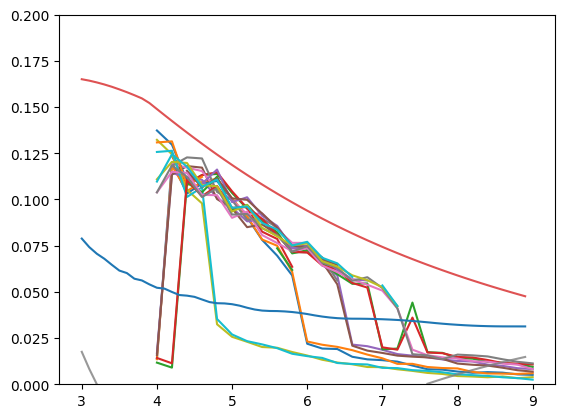

In [124]:
for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r+_total','r-_total']])
    plt.plot(KM_info['r_info'][['r+','r-']])

# plt.plot(KM_info2['r_info'][['r_mean','r+','r-']])


plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)
plt.plot(Ks_check2,F_R0d(Ks_check2))


# plt.plot(Ks_check2,rs_dFl2,color='tab:grey',alpha=0.8)
# plt.plot(Ks_check2,rs_uFl2,color='tab:red',alpha=0.8)
plt.ylim(0,0.2)